In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


### Initialize Tagger

In [2]:
from tagger import Tagger
tagger = Tagger()

### Load Model and Data

In [3]:
model_path = '/dfs/scratch0/chami/metal/logs/2019_02_20/RTE_21_25_34/'
task_name = 'RTE'
split = 'dev'
filepath = f'{task_name}_{split}_error_analysis.tsv'

In [4]:
# # Load model and data
# model, dl = load_data_and_model(model_path,task_name,split)

# # Create DataFrame of Raw Data, Predictions, and Labels
# print('Creating dataframe')
# df_error = create_dataframe(task_name, model, dl)
# print('Created dataframe')

# # Save (and reload) DataFrame
# csv_path = '/'.join(model_path.split('/')[0:-1])
# save_dataframe(df_error, filepath)

In [5]:
df_error = load_dataframe(filepath)

In [6]:
df_error.head()

,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,"dana reeve , the widow of the actor christoph...",christopher reeve had an accident .,0.003992,0,RTE/dev.tsv:2,0,False
1,1,"yet , we now are discovering that antibiotics...",bacteria is winning the war against antibioti...,0.003810,1,RTE/dev.tsv:3,0,True
2,2,cairo is now home to some 15 million people -...,15 million tonnes of rubbish are produced dai...,0.995439,0,RTE/dev.tsv:4,1,True
3,3,"the ami ##sh community in pennsylvania , whic...",pennsylvania has the biggest ami ##sh communi...,0.005520,0,RTE/dev.tsv:5,0,False
4,4,security forces were on high alert after an e...,security forces were on high alert after a ca...,0.993684,1,RTE/dev.tsv:6,1,False


## Sandbox for Error Analysis

**0. Some basic statistics.**

Confusion Matrix and Performance Metrics

In [7]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
confusion_matrix(Y_gold, Y_preds, pretty_print=True, normalize=True)
print()

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")

        y=1    y=2   
 l=1  *0.721  0.279  
 l=2   0.241 *0.759  

Accuracy: 0.736
Precision: 0.721
Recall: 0.815
F1: 0.765


Plotting Predictions and Predicted Probabilistic Label Distribution

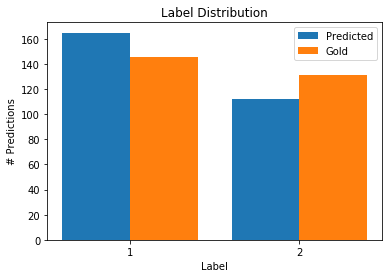

Accuracy:  0.7364620938628159


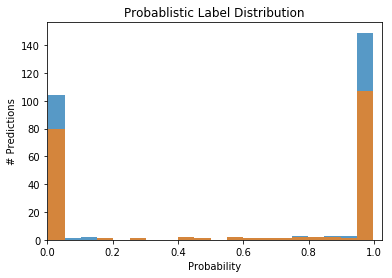

In [8]:
from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_histogram
    )
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_histogram(Y_probs, Y_gold, title="Probablistic Label Distribution", legend=[])

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [9]:
print("\033[1mBARELY WRONG\033[0;0m")
print_barely_wrong(df_error, thresh=0.2, n=3)

BARELY WRONG
No matches were found for the given criteria.


In [ ]:
print("\033[1mBARELY RIGHT\033[0;0m")
print_barely_right(df_error, thresh=0.2, n=3)

**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [57]:
tagger.add_tag("RTE/dev.tsv:181", 'number_mismatch')

Added 1 tag. Tag set 'number_mismatch' contains 2 tags.


In [53]:
print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.9, n=30)

VERY WRONG
69 matches were found with the given criteria.

UID:  RTE/dev.tsv:209
sentence1: 	 " bea arthur and i first met when we did ' ma ##me ' together in 1965 . she became and has remained ' my bo ##som buddy ' ever since . i am deeply sad ##dened by her passing , but also relieved that she is released from the pain . i spoke to matt , her son , yesterday and i was aware that her time was imminent . she was a rare and unique performer and a dear , dear friend . " arthur passed away at her home on saturday at the age of 86 . angela lan ##sbury is appearing in the current revival of b ##lit ##he spirit which began preview performances on thursday , february 26 , 2009 and had an official opening on sunday , march 15 , 2009 at the shu ##bert theatre ( 225 west 44th street ) . 
sentence2: 	 the actress angela lan ##sbury is 86 years old . 
score: 	0.9936
label: 	0

UID:  RTE/dev.tsv:129
sentence1: 	 in reality , legal ##ization would dramatically expand america ' s drug dependence , si

In [ ]:
print("\033[1mVERY RIGHT\033[0;0m")
print_very_right(df_error, thresh=0.9, n=3)

**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [ ]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(3):
    print_systematic_wrong(df_error)

# BH LFs

In [63]:
from metal.mmtl.debugging.utils import print_row, apply_lfs_to_df, view_matches
from metal.mmtl.debugging.lf_helpers import regex_present

In [67]:
def LF_accuse(row):
    return 2 if regex_present(row, "accuse") else 0

def LF_number_orphan(row):
    """Vote negative if sentence2 contains numbers not in sentence1"""
    sentence1_nums = set([int(s) for s in row["sentence1"].split() if s.isdigit()])
    sentence2_nums = set([int(s) for s in row["sentence2"].split() if s.isdigit()])
    sentence2_only_nums = sentence2_nums - sentence1_nums
    if len(sentence2_only_nums) > 0:
        return 2
    else:
        return 0

In [68]:
lfs = [
    LF_accuse,
    LF_number_orphan
]

In [70]:
L, Y = apply_lfs_to_df(df_error, lfs)

In [74]:
view_matches(df_error, lfs[1], n=0)

Displaying all 11 matches

sentence1: 	 monica meadows , a 22 - year - old model from atlanta , was shot in the shoulder on a subway car in new york city . 
sentence2: 	 monica meadows , 23 , was shot in shoulder while riding a subway car in new york city 
score: 	0.9879
label: 	0

sentence1: 	 a smaller proportion of yugoslavia ' s italians were settled in slovenia ( at the 1991 national census , some 3000 inhabitants of slovenia declared themselves as ethnic italians ) . 
sentence2: 	 slovenia has 3 , 000 inhabitants . 
score: 	0.9921
label: 	0

sentence1: 	 the tuesday drawing of the italian super ##ena ##lot ##to game has awarded the biggest prize ever won in a betting game in italy . the single winner of the first category prize ( 6 numbers guessed ) will receive an amount , including the jack ##pot from previous un - won draws , of € ##7 ##2 . 09 ##0 . 405 , 19 ( us $ 93 million . ) the prize money will be received in full without further taxation , since taxes in prizes of that 

In [72]:
from scipy.sparse import csr_matrix
from metal.analysis import lf_summary

Y_cat = convert_labels(Y, "onezero", "categorical")
lf_summary(csr_matrix(L), Y_cat)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,2.0,0.032491,0.0,0.0,5,4,0.555556
1,2.0,0.039711,0.0,0.0,6,5,0.545455


## Designing Labeling Functions

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

In [58]:
def LF_number(idx):
    sentence1_nums = [int(s) for s in df_error['sentence1'][idx].split() if s.isdigit()]
    sentence2_nums = [int(s) for s in df_error['sentence2'][idx].split() if s.isdigit()]
    common_nums = len(set(sentence1_nums).intersection(set(sentence2_nums)))
    
    if (sentence1_nums == []) or (sentence2_nums == []):
        return 0
    
    if common_nums > 0:
        return 2
    else:
        return 1

In [59]:
print_row(df_error.iloc[70])
print("LF_label: ", LF_number(70)-1)

print()
print()
print_row(df_error.iloc[254])
print("LF_label: ", LF_number(254)-1)

sentence1: 	 about 33 . 5 million people live in this massive con ##ur ##bation . i would guess that 95 % of the 5 , 000 officially foreign - capital firms in japan are based in tokyo . 
sentence2: 	 about 33 . 5 mi ##ili ##on people live in tokyo . 
score: 	0.0056
label: 	1

LF_label:  1


sentence1: 	 monica meadows , a 22 - year - old model from atlanta , was shot in the shoulder on a subway car in new york city . 
sentence2: 	 monica meadows , 23 , was shot in shoulder while riding a subway car in new york city 
score: 	0.9879
label: 	0

LF_label:  0


**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.

In [ ]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

from collections import Counter
def common_words(s1,s2):
    s1_set = set(Counter(s1.split()))
    s2_set = set(Counter(s2.split()))
    return len(s1_set.intersection(s2_set))/float(min(len(s1_set),len(s2_set)))

In [ ]:
def LF_words(idx):
    ratio = common_words(df_error['sentence1'][idx], df_error['sentence2'][idx])
    if ratio < 0.3:
        return 1
    if (ratio <= 1.0) and (ratio > 0.4):
        return 2
    else:
        return 0

In [ ]:
print_row(df_error.iloc[150])
print("LF_label: ", LF_words(150)-1)

print()
print()
print_row(df_error.iloc[95])
print("LF_label: ", LF_words(95)-1)

### Analyze Labeling Functions

In [ ]:
L = np.zeros((np.shape(df_error)[0],2))
for i in range(df_error.shape[0]):
    L[i,0] = LF_number(i)
    L[i,1] = LF_words(i)

Labeling Function Summary

In [ ]:
from metal.analysis import lf_summary
from scipy.sparse import csr_matrix    

L_sparse = csr_matrix(L)
lf_summary(L_sparse,Y=df_error.label+1)

In [ ]:
incorrect = set(np.where(df_error.is_wrong == True)[0])
LF1_set = set(np.where(L[:,0]-1. == df_error.label)[0])
LF2_set = set(np.where(L[:,1]-1. == df_error.label)[0])

print("Percentage Corrected by LF_num: ", 100.*len(LF1_set.intersection(incorrect))/float(len(incorrect)))
print("Percentage Corrected by LF_words: ", 100.*len(LF2_set.intersection(incorrect))/float(len(incorrect)))